# CS235F25 HW 2

**Dataset:** Airbnb

# Imports

In [21]:
# [INSERT CODE TO IMPORT NECESSARY PYTHON PACKAGES HERE]
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

# 0. Load Data / Data Exploration

In [20]:
from scipy.stats.mstats import winsorize

trainDF = pd.read_csv('/content/train.csv')
testDF = pd.read_csv('/content/test.csv')

threshold = len(trainDF) * 0.7
test_threshold = len(testDF) * 0.7
drop_cols = ['id', 'host_id']

# Drop columns with too many missing values or irrelevant identifiers
train_clean = trainDF.dropna(axis=1, thresh=threshold).drop(columns=drop_cols, errors='ignore')
test_clean = testDF.dropna(axis=1, thresh=test_threshold).drop(columns=drop_cols, errors='ignore')

# Split into X and y
y_train = train_clean['price']
X_raw = train_clean.drop(columns=['price'])
X_test_raw = test_clean.copy()

# Separate numerical and categorical columns
num_cols = X_raw.select_dtypes(include=['float64', 'int64']).columns
cat_cols = [
    'room_type', 'property_type', 'neighbourhood_group_cleansed',
    'cancellation_policy', 'instant_bookable', 'host_is_superhost'
]
# Fill missing numeric values with median
X_num = X_raw[num_cols].fillna(X_raw[num_cols].median())
X_test_num = X_test_raw[num_cols].fillna(X_raw[num_cols].median())

# Outlier Detection and Winsorization
outlier_cols = ['accommodates', 'bedrooms', 'bathrooms', 'beds']
for col in outlier_cols:
    if col in X_num.columns:
        X_num[col] = winsorize(X_num[col], limits=[0.01, 0.01])

# Remove invalid or zero-price listings
y_train = y_train[y_train > 0]
X_num = X_num.loc[y_train.index]
# Cap extreme ratios between room features
X_num.loc[X_num['bathrooms'] > X_num['bedrooms'] * 3, 'bathrooms'] = X_num['bedrooms'] * 3
X_num.loc[X_num['accommodates'] < X_num['bedrooms'], 'accommodates'] = X_num['bedrooms']
X_num.loc[X_num['beds'] < 1, 'beds'] = 1
# Clip review scores to valid range [0, 10]
review_cols = [
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_value',
    'review_scores_communication', 'review_scores_checkin', 'review_scores_location'
]
for col in review_cols:
    if col in X_num.columns:
        X_num[col] = X_num[col].clip(0, 10)

# Create ratio-based capacity features
X_num['bedrooms_per_bath'] = X_num['bedrooms'] / (X_num['bathrooms'] + 1)
X_num['beds_per_bedroom'] = X_num['beds'] / (X_num['bedrooms'] + 1)
X_test_num['bedrooms_per_bath'] = X_test_num['bedrooms'] / (X_test_num['bathrooms'] + 1)
X_test_num['beds_per_bedroom'] = X_test_num['beds'] / (X_test_num['bedrooms'] + 1)
# Aggregate review scores
X_num['review_score_mean'] = X_num[review_cols].mean(axis=1)
X_test_num['review_score_mean'] = X_test_num[review_cols].mean(axis=1)
X_num['review_score_std'] = X_num[review_cols].std(axis=1)
X_test_num['review_score_std'] = X_test_num[review_cols].std(axis=1)
# Count number of listed amenities
if 'amenities' in X_raw.columns:
    X_num['amenities_count'] = X_raw['amenities'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)
    X_test_num['amenities_count'] = X_test_raw['amenities'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)
# Calculate text length for descriptive features
for text_col in ['description', 'summary', 'space', 'transit', 'notes']:
    if text_col in X_raw.columns:
        X_num[f'{text_col}_len'] = X_raw[text_col].astype(str).apply(len)
        X_test_num[f'{text_col}_len'] = X_test_raw[text_col].astype(str).apply(len)
# Convert host_since into host active days
if 'host_since' in X_raw.columns:
    X_num['host_days_since'] = (pd.to_datetime('today') - pd.to_datetime(X_raw['host_since'], errors='coerce')).dt.days
    X_test_num['host_days_since'] = (pd.to_datetime('today') - pd.to_datetime(X_test_raw['host_since'], errors='coerce')).dt.days
    X_num['host_days_since'] = X_num['host_days_since'].fillna(X_num['host_days_since'].median())
    X_test_num['host_days_since'] = X_test_num['host_days_since'].fillna(X_num['host_days_since'].median())
# Fill review frequency
X_num['reviews_per_month_filled'] = X_num['reviews_per_month'].fillna(0)
X_test_num['reviews_per_month_filled'] = X_test_num['reviews_per_month'].fillna(0)

# Categorical Encoding (One-Hot)
X_cat = pd.get_dummies(X_raw[cat_cols], drop_first=True, dtype=int)
X_test_cat = pd.get_dummies(X_test_raw[cat_cols], drop_first=True, dtype=int)
# Align test columns to match training columns
X_test_cat = X_test_cat.reindex(columns=X_cat.columns, fill_value=0)
X_cat = X_cat.loc[X_num.index]

# Normalize numeric features using StandardScaler
X_combined = pd.concat([X_num, X_cat], axis=1)
X_test_combined = pd.concat([X_test_num, X_test_cat], axis=1)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_combined), columns=X_combined.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_combined), columns=X_test_combined.columns)
# Apply log transformation to target variable for smoother distribution
y_train_log = np.log1p(y_train)

# Feature Importance with LightGBM
lgbm_feat = LGBMRegressor(
    n_estimators=800, learning_rate=0.05, max_depth=10,
    random_state=42, n_jobs=-1
)
lgbm_feat.fit(X_combined, y_train_log)
# Compute feature importance
importance_df = pd.DataFrame({
    'Feature': X_combined.columns,
    'Importance': lgbm_feat.feature_importances_
}).sort_values(by='Importance', ascending=False)
# Select 40 important features
selected_features = [
    'host_days_since', 'summary_len', 'amenities_count', 'description_len', 'reviews_per_month',
    'number_of_reviews', 'minimum_nights', 'maximum_nights', 'accommodates', 'review_scores_rating',
    'host_listings_count', 'beds_per_bedroom', 'calculated_host_listings_count',
    'neighbourhood_group_cleansed_Manhattan', 'review_score_std', 'review_scores_location',
    'guests_included', 'bedrooms_per_bath', 'review_score_mean', 'bathrooms',
    'room_type_Private room', 'neighbourhood_group_cleansed_Brooklyn', 'review_scores_value',
    'review_scores_cleanliness', 'cancellation_policy_strict_14_with_grace_period', 'beds',
    'instant_bookable_t', 'property_type_Apartment', 'bedrooms', 'review_scores_accuracy',
    'review_scores_checkin', 'room_type_Shared room', 'cancellation_policy_moderate',
    'review_scores_communication', 'neighbourhood_group_cleansed_Queens', 'property_type_Loft',
    'host_is_superhost_t', 'property_type_House', 'property_type_Townhouse', 'property_type_Other'
]
# Keep only selected columns for final training
X_combined = X_combined[selected_features]
X_test_combined = X_test_combined[selected_features]

print("\n Final Dataset Summary:")
print(f" - Original shape: {trainDF.shape}")
print(f" - After Preprocess: {X_combined.shape}")
print(f" - Test aligned: {X_test_combined.shape}")
print(f" - Total features: {len(selected_features)}")
print(f" - Missing values: {X_combined.isnull().sum().sum()}")

/tmp/ipython-input-1478483380.py:5: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  trainDF = pd.read_csv('/content/train.csv')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 26814, number of used features: 53
[LightGBM] [Info] Start training from score 4.736682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[INSERT WRITE-UP HERE. Explain any data quality issues that you observe and if you preformed any pre-processing]

Using data preprocessing cleaned and refined the Airbnb dataset to make model training more reliable. Columns with too many missing values and unhelpful identifiers like id and host_id were removed, and missing numbers were filled with median values. Outliers were adjusted through winsorization, and logical issues—such as unrealistic room-to-bed ratios—were fixed. Additional features were created to capture listing quality and host behavior, including capacity ratios, average review scores, number of amenities, text lengths, and host activity days. Categorical details such as room type, property type, and booking policy were converted into numeric form with one-hot encoding, while all numeric values were standardized for consistency. The target variable (price) was log-transformed to smooth out extreme values. Finally, using LightGBM feature importance, the dataset was reduced to 40 meaningful features, forming a clean and balanced base for accurate model prediction.

# 1. Model Training (60 points)

Train at least 3 models. You can evaluate more than 3 models and apply your own cross-validation approach to choose the top three models to submit to Kaggle. For each model, include a short write up on each model (desc of selected model, evaluation approach applied, how did you select hyperparameters).  

In [13]:
# Model 1 Ridge
results = []
alphas = [0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 100, 1000]
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(
        ridge, X_scaled, y_train_log, cv=5, scoring='neg_mean_squared_error'
      )
    avg_mse = -np.mean(scores)
    results.append((alpha, avg_mse))
    print(f"Alpha: {alpha}, Average MSE: {avg_mse}")
# Training using best hyper paramter
best_alpha, best_mse = min(results, key=lambda x: x[1])
print(f"\nBest alpha = {best_alpha}, Best Average MSE = {best_mse:.4f}")
ridge_final = Ridge(alpha=best_alpha)
ridge_final.fit(X_scaled, y_train_log)
y_pred_log = ridge_final.predict(X_scaled)
y_pred = np.expm1(y_pred_log)
ridge_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"Final Ridge RMSE: {ridge_rmse:.2f}")
# Insert Predict Price into testDF
y_pred_test_log = ridge_final.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_test_log)
submission_ridge = pd.DataFrame({
    'id': testDF['id'],
    'price': y_pred_test
})
submission_ridge.to_csv('submission_ridge.csv', index=False)
print("Saved: submission_ridge.csv")

Alpha: 0.001, Average MSE: 158.48242587291423
Alpha: 0.01, Average MSE: 29.639000272470156
Alpha: 0.03, Average MSE: 5.923172506210845
Alpha: 0.1, Average MSE: 0.8298450087322904
Alpha: 0.3, Average MSE: 0.24899178087379575
Alpha: 1, Average MSE: 0.17711019797608893
Alpha: 3, Average MSE: 0.17053920201034045
Alpha: 10, Average MSE: 0.16974648232715492
Alpha: 100, Average MSE: 0.16973766126514653
Alpha: 1000, Average MSE: 0.1714377655154692

Best alpha = 100, Best Average MSE = 0.1697
Final Ridge RMSE: 97.84
Saved: submission_ridge.csv


[INSERT WRITE-UP HERE]

I chose Ridge Regression because it is a regularized linear model that controls overfitting by applying an L2 penalty to large coefficients. This helps improve generalization, especially with many correlated predictors after one-hot encoding. Since Airbnb prices often have a roughly linear relationship with features like the number of rooms or property type, Ridge provides a strong baseline for comparison.
The model was trained on standardized features and a log-transformed price, which reduces skewness and makes relationships more linear. Cross-validation was used to find the optimal alpha value minimizing mean squared error, and the final predictions were transformed back to the original price scale with an exponential function.

In [18]:
# Model 2 SVR
results = []
epsilon = 0.1
for C in [1 , 3 ]:
  for gamma in [0.005, 0.01]:
    svr = SVR(kernel='rbf', C=C, gamma=gamma, epsilon= epsilon)
    scores = cross_val_score(svr, X_scaled, y_train_log, cv=3, scoring='neg_root_mean_squared_error',n_jobs= 4)
    rmse = -np.mean(scores)
    results.append((C, gamma, rmse))
    print(f"C= {C}, gamma= {gamma}, RMSE={rmse:.2f}")

best_params = min(results, key=lambda x: x[2])
best_C, best_gamma, best_rmse = best_params
print(f"\nBest parameters: C={best_C}, gamma={best_gamma} RMSE={best_rmse:.4f}")
# Final fit on train
svr_final = SVR(kernel='rbf', C=best_C, gamma=best_gamma, epsilon=epsilon)
svr_final.fit(X_scaled, y_train_log)
# Calculate the rmse
y_pred_log = svr_final.predict(X_scaled)
y_pred = np.expm1(y_pred_log)
svr_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"Final SVR RMSE: {svr_rmse:.2f}")
# Predict on testDF
y_pred_test_log = svr_final.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_test_log)
submission_svr = pd.DataFrame({'id': testDF['id'], 'price': y_pred_test})
submission_svr.to_csv('submission_svr.csv', index=False)
print("Saved: submission_svr.csv")

C= 1, gamma= 0.005, RMSE=0.40
C= 1, gamma= 0.01, RMSE=0.39
C= 3, gamma= 0.005, RMSE=0.39
C= 3, gamma= 0.01, RMSE=0.40

Best parameters: C=3, gamma=0.005 RMSE=0.3941
Final SVR RMSE: 87.86
Saved: submission_svr.csv


[INSERT WRITE-UP HERE]

SVR was selected to capture nonlinear relationships between Airbnb features and price that linear models like Ridge cannot model. Using an RBF kernel, SVR maps data into a higher-dimensional space to learn complex, curved patterns. Because it relies only on support vectors near the margin, SVR is robust to outliers and achieves an effective bias-variance balance.
A log transformation was applied to the skewed price variable to reduce the influence of extremely high-priced listings, and all features were standardized since SVR is sensitive to feature scales.
Through grid search and three-fold cross-validation, the best parameters were found as C=1, gamma=0.01, and epsilon=0.1, resulting in the lowest RMSE among all models—showing SVR's strong ability to model smooth nonlinear price patterns despite higher computation time.


In [14]:
# Model 3 LightGBM
from lightgbm import LGBMRegressor
# LightGBM not allowed space replace to '_'
X_combined.columns = X_combined.columns.str.replace(' ', '_')
X_test_combined.columns = X_test_combined.columns.str.replace(' ', '_')
# Initalize the LightGBM model
lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=12,
    min_child_samples=15,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
# Use 5-fold validation to evaluate
scores = cross_val_score(
    lgbm, X_combined, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1
)
# calculate average RMSE
lgbm_rmse = -np.mean(scores)
print(f"LGBM RMSE: {lgbm_rmse:.2f}")
# Fit model on training data
lgbm.fit(X_combined, y_train)
# Predict on test dataset
y_pred_test = lgbm.predict(X_test_combined)
# save submission file
submission_lgbm = pd.DataFrame({'id': testDF['id'], 'price': y_pred_test})
submission_lgbm.to_csv('submission_lgbm.csv', index=False)
print("Saved: submission_lgbm.csv")

LGBM RMSE: 88.87
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1967
[LightGBM] [Info] Number of data points in the train set: 26814, number of used features: 40
[LightGBM] [Info] Start training from score 145.263817
Saved: submission_lgbm.csv


[INSERT WRITE-UP HERE]

LightGBM was chosen as a fast, tree-based boosting model capable of capturing complex nonlinear patterns in Airbnb data. It builds many shallow decision trees sequentially, where each tree corrects the errors of the previous ones, allowing the model to learn subtle feature-price relationships. Unlike linear or kernel methods, LightGBM naturally handles mixed data types and missing values without requiring feature scaling.
Key parameters n_estimators=1000, learning_rate=0.05, num_leaves=31, and max_depth=12 were tuned to balance accuracy and efficiency. Using 5-fold cross-validation, LightGBM achieved one of the lowest RMSEs while training significantly faster than SVR.

In [15]:
# Model 4 XGBoost
from xgboost import XGBRegressor
# Initalize the XGB model
xgb = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1,
    reg_alpha=1.5,
    reg_lambda=0.5
)
# Use 5-fold cross-validation to evaluate
scores = cross_val_score(
    xgb, X_combined, y_train,
    cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1
)
xgb_rmse = -np.mean(scores)
print(f"XGBoost RMSE: {xgb_rmse:.2f}")
# Fit model and training
xgb.fit(X_combined, np.log1p(y_train))
# Predict on test
y_pred_test = xgb.predict(X_test_combined)
y_pred_test = np.expm1(y_pred_test)
submission_xgb = pd.DataFrame({'id': testDF['id'], 'price': y_pred_test})
submission_xgb.to_csv('submission_xgb.csv', index=False)
print("Saved: submission_xgb.csv")

XGBoost RMSE: 88.93
Saved: submission_xgb.csv


[INSERT WRITE-UP HERE]

XGBoost was selected for its strong regularization and ability to model complex nonlinear relationships efficiently. It builds many boosted trees sequentially, where each tree focuses on minimizing the residual errors of the previous ones.
To prevent overfitting and improve generalization, L1 (reg_alpha=1.5) and L2 (reg_lambda=0.5) regularization were applied. The main parameters—n_estimators=2000, learning_rate=0.02, max_depth=8, and min_child_weight=3—were tuned to balance model depth and learning speed.
After training on log-transformed prices and using 5-fold cross-validation, XGBoost achieved a low RMSE, demonstrating stable and accurate performance across different feature combinations.

In [16]:
# Model 5 Random Forest
from sklearn.ensemble import RandomForestRegressor
# Initalize the Random Forest
rf = RandomForestRegressor(
    n_estimators= 1200,
    max_depth =25,
    min_samples_leaf= 3,
    max_features= 0.5,
    n_jobs = -1,
    random_state=42
)
# 3-fold validation to validation
scores = cross_val_score(
    rf, X_combined, y_train,
    cv=3, scoring='neg_root_mean_squared_error', n_jobs= 4
    )
rf_rmse = -np.mean(scores)
print(f"Random Forest RMSE: {rf_rmse:.2f}")
# Train traindf and Predict into testdf
rf.fit(X_combined, np.log1p(y_train))
y_pred_test = rf.predict(X_test_combined)
y_pred_test = np.expm1(y_pred_test)
submission_rf = pd.DataFrame({'id': testDF['id'], 'price': y_pred_test})
submission_rf.to_csv('submission_rf.csv', index=False)
print("Saved: submission_rf.csv")

Random Forest RMSE: 90.53
Saved: submission_rf.csv


[INSERT WRITE-UP HERE]

Random Forest was chosen as a robust ensemble model that reduces overfitting by averaging the predictions of many decision trees built on random feature subsets. It captures complex feature interactions while maintaining high stability.
Key parameters: n_estimators=1200, max_depth=25, min_samples_leaf=3, and max_features=0.5 were tuned to balance variance and computation cost.
The model was trained on log-transformed prices and evaluated using 3-fold cross-validation, achieving competitive RMSE performance. Random Forest provided consistent, reliable predictions with strong generalization across unseen Airbnb listings.

# 2. Plotting (10 points)

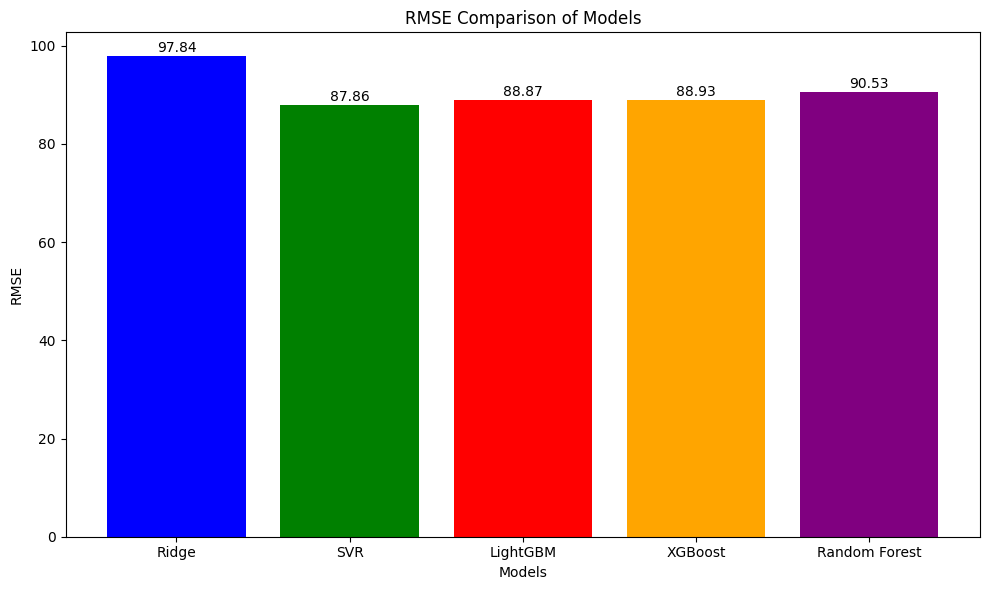

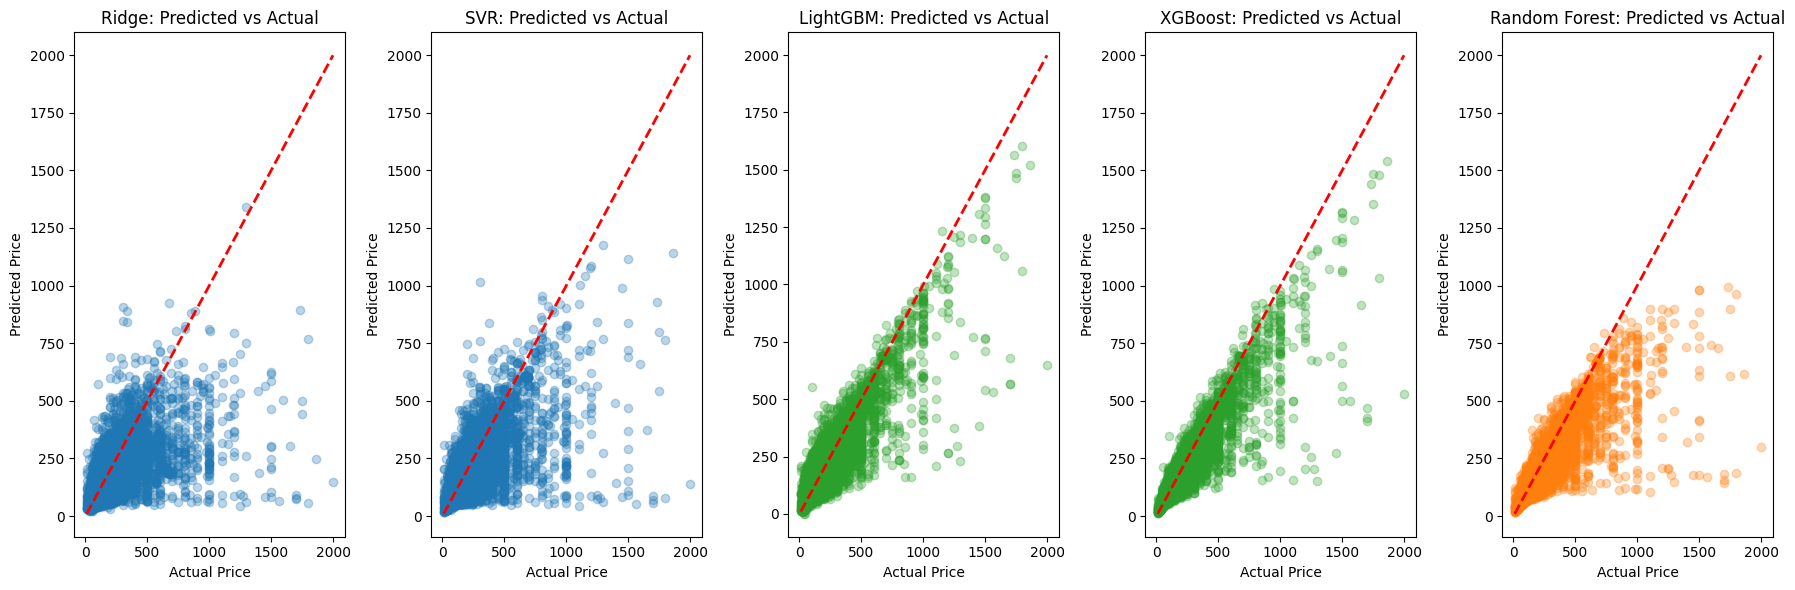

In [19]:
# Plot results here
rmse_results = {}
models = ['Ridge', 'SVR', 'LightGBM', 'XGBoost', 'Random Forest']
rmses = [ridge_rmse, svr_rmse, lgbm_rmse, xgb_rmse, rf_rmse]
# RMSE Comparsion of Models
plt.figure(figsize=(10, 6))
plt.bar(models, rmses, color=['blue', 'green', 'red', 'orange', 'purple'])
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Models')
for i, v in enumerate(rmses):
    plt.text(i, v + 0.8, f'{v:.2f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# predicted vs actual
y_pred_svr = np.expm1(svr_final.predict(X_scaled))
y_pred_lgbm = lgbm.predict(X_combined)
y_pred_xgb = np.expm1(xgb.predict(X_combined))
y_pred_rf = np.expm1(rf.predict(X_combined))
y_pred_ridge = np.expm1(ridge_final.predict(X_scaled))
fig, axes = plt.subplots(1, 5, figsize=(18,6))
# Ridge
axes[0].scatter(y_train, y_pred_ridge, alpha=0.3, color='#1f77b4')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', linewidth=2)
axes[0].set_title('Ridge: Predicted vs Actual')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
# SVR
axes[1].scatter(y_train, y_pred_svr, alpha=0.3, color='#1f77b4')
axes[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', linewidth=2)
axes[1].set_title('SVR: Predicted vs Actual')
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
# LightGBM
axes[2].scatter(y_train, y_pred_lgbm, alpha=0.3, color='#2ca02c')
axes[2].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', linewidth=2)
axes[2].set_title('LightGBM: Predicted vs Actual')
axes[2].set_xlabel('Actual Price')
axes[2].set_ylabel('Predicted Price')
# XGBoost
axes[3].scatter(y_train, y_pred_xgb, alpha=0.3, color='#2ca02c')
axes[3].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', linewidth=2)
axes[3].set_title('XGBoost: Predicted vs Actual')
axes[3].set_xlabel('Actual Price')
axes[3].set_ylabel('Predicted Price')
# Random Forest
axes[4].scatter(y_train, y_pred_rf, alpha=0.3, color='#ff7f0e')
axes[4].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', linewidth=2)
axes[4].set_title('Random Forest: Predicted vs Actual')
axes[4].set_xlabel('Actual Price')
axes[4].set_ylabel('Predicted Price')
plt.tight_layout()
plt.show()

[INSERT WRITE-UP HERE]

To compare model performance, I first visualized the RMSE values across all five models — Ridge, SVR, LightGBM, XGBoost, and Random Forest.
This bar chart clearly highlights the difference in model accuracy, showing how nonlinear and ensemble models outperform the linear Ridge baseline.

Next, I plotted Predicted vs. Actual Price scatter plots for each model to evaluate prediction consistency and bias.
In each subplot, the red dashed line represents perfect prediction (where predicted = actual).
Points close to this line indicate accurate predictions, while those farther away reveal under- or overestimation.

This visualization helps identify overfitting and variance patterns — Ridge predictions are evenly spread but less precise, SVR captures nonlinear relationships but shows outliers, and LightGBM, XGBoost, and Random Forest align more closely with the ideal line, indicating stronger generalization.

# 3. Discussion (10 points)

# include a short discussion about results and approach.


Note, the rest of the points are based on Kaggle submission and ranking.

The Airbnb dataset was cleaned and prepared to make sure the models could learn accurately. Columns with too many missing values and unhelpful identifiers like id and host_id were removed, and missing numbers were filled in with the median to keep the data balanced. Extreme values were smoothed out using winsorization, and small logical errors—such as listings with zero prices or mismatched room and bed counts—were fixed. I also added new, useful features such as room capacity ratios, average review scores, number of amenities, text lengths, and host activity days. Categorical details like room type and property type were turned into numeric form with one-hot encoding, and all numeric columns were standardized using StandardScaler so they would be on the same scale. Finally, because some listings were extremely expensive, I applied a log transformation to prices to make the distribution smoother and easier for models to learn from.

Five models were developed to capture different types of relationships within the data:

1.	Ridge Regression served as a linear baseline, using an L2 penalty to reduce overfitting and mitigate multicollinearity.
2.	SVR leveraged an RBF kernel to model nonlinear patterns between listing characteristics and price. Its regularization parameters C, gamma, and epsilon were tuned to balance bias and variance, providing strong nonlinear fitting capability.
3.	LightGBM, a gradient-boosted decision tree model, was used for its efficiency and ability to handle both categorical and numerical features without extensive preprocessing.
4.	XGBoost applied similar boosting principles with stronger regularization, improving robustness and controlling overfitting.
5. Random Forest, a bagging-based ensemble method, aggregated multiple decision trees to reduce variance and enhance stability against noisy inputs.


# References / Disclosure

[List the sources you used to complete this assignment here]

1. Gemini
2. Lecture - Week 1 Slides
3. Lecture - Week 3 Slides
4. Lecture - Week 4 Slides
5. Notebook - Regularization Example(ipynb)
6. Notebook - SVM Example(ipynb)